# GoogLeNet
- top5 error rate: 6.7%
- 22 layer deep, deep convolutional network for image classification
- does not use multiple dense layers but instead employs pooling layers with small filters
- uses a network-in-network module called the Inception Module
- original model takes images of size 224x224x3 as input
- has filters ranging from 1×1 to 5×5, ReLU activation for convolutional layers, and dropout layers for regularization

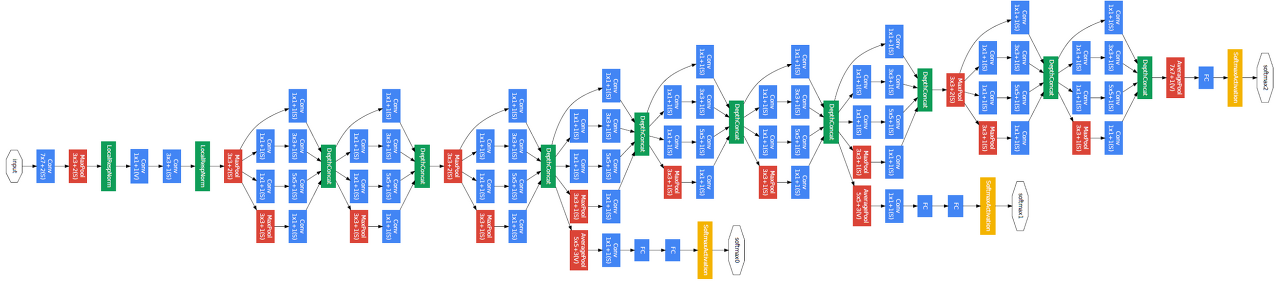

In [ ]:
display.Image('https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fk.kakaocdn.net%2Fdn%2FIq9NO%2FbtqyPWk5PBX%2FK2JicGjIjj5w0eFIbhx4bK%2Fimg.png')

### 1. 1 X 1 Convolution: 1x1 사이즈의 필터로 convoltuion
- 특성맵의 개수를 줄이는 목적으로 사용; 특성맵의 개수가 줄어들면 그만큼 연산량이 줄어듦
- 여러 개의 convolution을 병렬적으로 사용

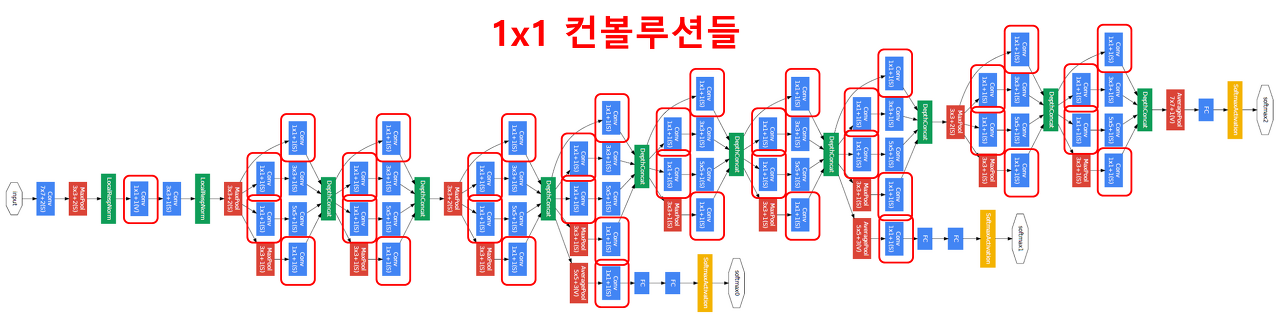

In [ ]:
display.Image('https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fk.kakaocdn.net%2Fdn%2FMzPze%2FbtqyQy5e3NM%2F5HPtmAwVQzKJTj6wgWautk%2Fimg.png')

### 2. Inception Module --> 9개의 모듈 있음
- 다른 모델들과의 차이점: AlexNet, VGGNet 등의 이전 CNN 모델들은 한 층에서 동일한 사이즈의 필터커널을 이용해서 컨볼루션
- ==> 더 다양한 종류의 특성이 도출, 연산량 줄어듦
-  1x1 Convolution으로 Feature map의 차원 수를 줄일 수 있음
- Max pooling이 있는 Layer에서는 1x1 Convolution 보다 Max pooling을 먼저 실시 --> ?) Max pooling이 Feature map의 개수 (Channel 수)를 조정할 수 없기 때문

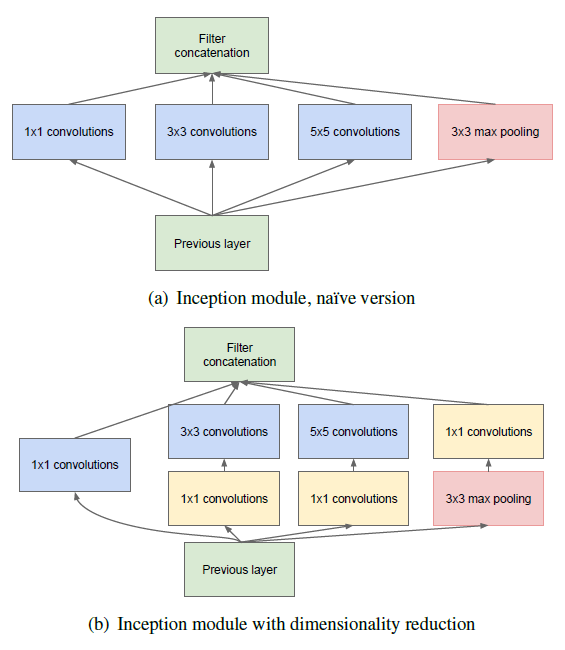

In [ ]:
display.Image('https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fk.kakaocdn.net%2Fdn%2F14Um2%2FbtqyQ5nKlEA%2FhjSsZaYiBukseySytXWFCK%2Fimg.png')

### 3. Global Average Pooling: 전 층에서 산출된 특성맵들을 각각 평균낸 것을 이어서 1차원 벡터를 만들어주는 것
- fully connected layers --> 신경망의 후반에 X
- 1차원 벡터를 만들어줘야 최종적으로 이미지 분류를 위한 softmax 층을 연결할 수 있음
- FC 방식 --> 가중치의 개수가 상당히 많음 (7 x 7 x 1024 x 1024 = 51.3M)
- 가중치가 단 한 개도 필요하지 않음

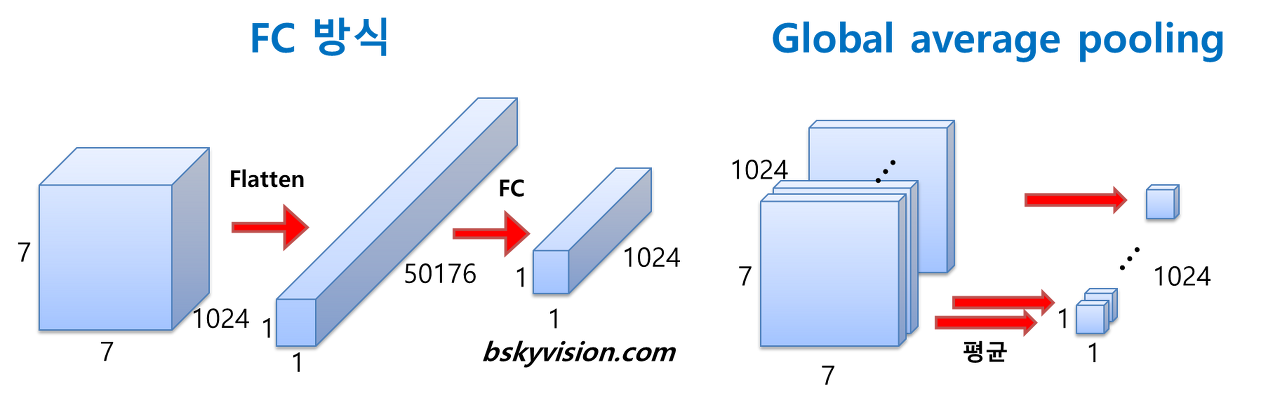

In [ ]:
from IPython import display
display.Image("https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fk.kakaocdn.net%2Fdn%2FbwTHh0%2FbtqB2uyArWI%2FqBr48Ik8bl4bK1oOEJa3bk%2Fimg.png")

### 4. Auxiliary Classifier: solves vanishing gradient problem
- 네트워크의 깊이가 깊어지면 깊어질수록 vanishing gradient 문제를 피하기 어려워짐
- problem: back propogation 과정에서 가중치를 업데이트하는데 사용되는 gradient가 점점 작아져서 0이 되어버림 ==> 가중치 제대로 훈련 X
- solution: 네트워크 중간에 두 개의 보조 분류기(auxiliary classifier)를 달아줌
- 5 x 5 평균 풀링(stride 3) -> 128개 1x1 필터커널로 컨볼루션 -> 1024 FC 층 -> 1000 FC 층 -> softmax

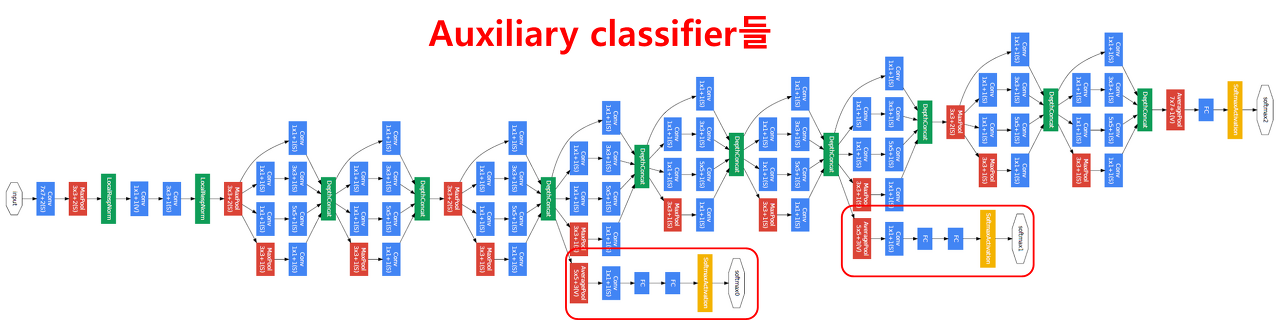

In [ ]:
display.Image('https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fk.kakaocdn.net%2Fdn%2FbD5poT%2FbtqyQM98EkX%2FnbxasUSmCO1WnaIyIsvUD0%2Fimg.png')

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
hel=os.listdir('/content/drive/MyDrive/helmet_project/croped/helmet')
no_hel=os.listdir('/content/drive/MyDrive/helmet_project/croped/no_helmet')
print(len(hel),len(no_hel))

536 722


In [ ]:
import splitfolders
input_folder = '/content/drive/MyDrive/helmet_project/croped'

splitfolders.ratio(input_folder,
                   output = '/content/drive/MyDrive/helmet_project/split_data2',
                   seed = 1337,
                   ratio = (0.7, 0.2,0.1), #train/valid/test split ratio
                   group_prefix = None)

Copying files: 1258 files [00:10, 117.32 files/s]


In [ ]:
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout, concatenate
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
data_with_augmentation = ImageDataGenerator(rotation_range = 30,
                                            width_shift_range = 0.2,
                                            height_shift_range = 0.2,
                                            fill_mode='constant',
                                            horizontal_flip = True,
                                            brightness_range = (0.5, 1.5),
                                            shear_range=0.2,
                                            rescale = 1/255.0) #train data 증강 방식

In [ ]:
train_data_generator = data_with_augmentation.flow_from_directory(directory = '/content/drive/MyDrive/helmet_project/split_data2/train',
                                                                  classes=['helmet','no_helmet'],
                                                                  target_size = (224, 224),
                                                                  class_mode = 'categorical', #binary로 진행도 해봄
                                                                  batch_size = 32)

Found 943 images belonging to 2 classes.


In [ ]:
train_data_generator.class_indices

{'helmet': 0, 'no_helmet': 1}

In [ ]:
data_no_augmentation = ImageDataGenerator(rescale=1 / 255.0) #valid와 test 는 증강없이 스케일링만 진행

In [ ]:
val_data_generator = data_no_augmentation.flow_from_directory(directory = '/content/drive/MyDrive/helmet_project/split_data2/val',
                                                              target_size = (224, 224),
                                                              classes=['helmet','no_helmet'],
                                                              class_mode = 'categorical', #binary로 진행도 해봄
                                                              batch_size = 32)

test_data_generator = data_no_augmentation.flow_from_directory(directory = '/content/drive/MyDrive/helmet_project/split_data2/test',
                                                              target_size = (224, 224),
                                                              classes=['helmet','no_helmet'],
                                                              class_mode = 'categorical', #binary로 진행도 해봄
                                                              batch_size = 32)

Found 251 images belonging to 2 classes.
Found 127 images belonging to 2 classes.


In [ ]:
def Inception(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4, name = None):
    # Input:
    # f1: number of filters of the 1x1 convolutional layer in the first path
    # f2_conv1, f2_conv3: number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
    # f3_conv1, f3_conv5: number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
    # f4: number of filters of the 1x1 convolutional layer in the fourth path

    # 1st path:
    path1 = Conv2D(filters = f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

    # 2nd path
    path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

    # 3rd path
    path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

    # 4th path
    path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
    path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

    output_layer = concatenate([path1, path2, path3, path4], axis = -1, name = name)

    return output_layer

In [ ]:
def Auxiliary(input_layer, pool, stride, f_conv, kernel_conv, a1, a2, d1, dropout, d2, name = None):
    # pool: pool size of average pooling 2D layer
    # stride: amount of strides in average pooling 2D layer
    # f_conv: number of filters of convolutional layer
    # kernel_conv: kernel size of convolutional layer
    # d1: the first FC layer's dense unit
    # dropout: fraction of the input units to drop
    # d2: the second FC layer's dense unit
    # a1, a2: activation functions of each dense layer

    # 5x5 average pooling
    layer1 = AveragePooling2D(pool_size = pool, strides = stride)(input_layer)
    # 1x1 convolutional layer
    layer2  = Conv2D(filters = f_conv, kernel_size = kernel_conv, padding = 'valid', activation = 'relu')(layer1)
    # FC
    layer3 = Flatten()(layer2)
    layer4 = Dense(d1, activation = a1)(layer3)
    # FC
    layer5 = Dropout(dropout)(layer4)
    output_layer = Dense(d2, activation = a2, name = name)(layer5) # target이 0,1로 binary할 때는 d2=1 & a2='sigmoid #target이 one hot encoding형태로 categorical할 때는 d2=1 & a2='softmax'

    return output_layer

In [ ]:
def GoogLeNet():
    input_layer = Input(shape = (224, 224, 3))

    X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'same', activation = 'relu', name = 'conv1')(input_layer)

    X = MaxPooling2D(pool_size = (3,3), strides = 2, name = 'maxpool1')(X)

    X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'valid', activation = 'relu', name = 'conv2a')(X)

    X = Conv2D(filters = 192, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu', name = 'conv2b')(X)

    X = MaxPooling2D(pool_size = (3,3), strides = 2, name = 'maxpool2')(X)

    X = Inception(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32, name = 'inception3a')

    X = Inception(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64, name = 'inception3b')

    X = MaxPooling2D(pool_size = (3,3), strides = 2, name = 'maxpool3')(X)

    X = Inception(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64, name = 'inception4a')

    X1 = Auxiliary(X, pool = (5,5), stride = 3, f_conv = 128, kernel_conv = (1,1),
                   d1 = 1024, dropout = 0.7, a1 = 'relu',
                   d2 = 2, a2 = 'softmax', name = 'auxiliary1') #위 block의 주석에 적힌 설명에 따라 d2,a2 매개변수 조정 

    X = Inception(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64, name = 'inception4b')

    X = Inception(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64, name = 'inception4c')

    X = Inception(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64, name = 'inception4d')

    X2 = Auxiliary(X, pool = (5,5), stride = 3, f_conv = 128, kernel_conv = (1,1),
                   d1 = 1024, dropout = 0.7, a1 = 'relu',
                   d2 = 2, a2 = 'softmax', name = 'auxiliary2') #위 block의 주석에 적힌 설명에 따라 d2,a2 매개변수 조정

    X = Inception(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128, name = 'inception4e')

    X = MaxPooling2D(pool_size = (3,3), strides = 2, name = 'maxpool4')(X)

    X = Inception(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128, name = 'inception5a')

    X = Inception(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128, name = 'inception5b')

    X = GlobalAveragePooling2D(name = 'GAPL')(X)

    X = Dropout(0.4)(X)

    X = Dense(2, activation = 'softmax', name = 'output')(X) #위 block의 주석에 적힌 설명 처럼 dense net 조정

    model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')
    return model

In [ ]:
model = GoogLeNet()
model.summary()

In [ ]:
from keras import optimizers
from keras import losses
from keras.callbacks import ModelCheckpoint
#sgd = optimizers.SGD(lr = 0.001, momentum = 0.9, decay = 1e-6, nesterov = True)
opt = optimizers.Adam(learning_rate = 0.001)
chk = ModelCheckpoint('helmet_clf.pkl', monitor='val_loss', save_best_only=True, mode='min', verbose=1) #val_loss 가 가장 적은 것으로
# model compile #loss = output loss와 aux loss를 적절히 조합
model.compile(optimizer = opt, loss=[losses.binary_crossentropy,losses.binary_crossentropy,losses.binary_crossentropy],loss_weights=[1, 0.3, 0.3],metrics=['accuracy'])
# model fit
history = model.fit(train_data_generator, validation_data = val_data_generator, epochs = 100, callbacks=[chk])

Epoch 1/100
30/30 [==============================] - ETA: 0s - loss: 1.1051 - output_loss: 0.6908 - auxiliary1_loss: 0.6919 - auxiliary2_loss: 0.6888 - output_accuracy: 0.5302 - auxiliary1_accuracy: 0.5440 - auxiliary2_accuracy: 0.5493
Epoch 1: val_loss improved from inf to 1.09252, saving model to helmet_clf.pkl


30/30 [==============================] - 29s 838ms/step - loss: 1.1051 - output_loss: 0.6908 - auxiliary1_loss: 0.6919 - auxiliary2_loss: 0.6888 - output_accuracy: 0.5302 - auxiliary1_accuracy: 0.5440 - auxiliary2_accuracy: 0.5493 - val_loss: 1.0925 - val_output_loss: 0.6831 - val_auxiliary1_loss: 0.6813 - val_auxiliary2_loss: 0.6836 - val_output_accuracy: 0.5737 - val_auxiliary1_accuracy: 0.5737 - val_auxiliary2_accuracy: 0.5737
Epoch 2/100
30/30 [==============================] - ETA: 0s - loss: 1.0918 - output_loss: 0.6829 - auxiliary1_loss: 0.6799 - auxiliary2_loss: 0.6832 - output_accuracy: 0.5737 - auxiliary1_accuracy: 0.5758 - auxiliary2_accuracy: 0.5737
Epoch 2: val_loss improved from 1.09252 to 1.08368, saving model to helmet_clf.pkl


30/30 [==============================] - 31s 1s/step - loss: 1.0918 - output_loss: 0.6829 - auxiliary1_loss: 0.6799 - auxiliary2_loss: 0.6832 - output_accuracy: 0.5737 - auxiliary1_accuracy: 0.5758 - auxiliary2_accuracy: 0.5737 - val_loss: 1.0837 - val_output_loss: 0.6822 - val_auxiliary1_loss: 0.6562 - val_auxiliary2_loss: 0.6819 - val_output_accuracy: 0.5737 - val_auxiliary1_accuracy: 0.5896 - val_auxiliary2_accuracy: 0.5737
Epoch 3/100
30/30 [==============================] - ETA: 0s - loss: 1.0839 - output_loss: 0.6844 - auxiliary1_loss: 0.6473 - auxiliary2_loss: 0.6843 - output_accuracy: 0.5620 - auxiliary1_accuracy: 0.6426 - auxiliary2_accuracy: 0.5652
Epoch 3: val_loss did not improve from 1.08368
30/30 [==============================] - 16s 522ms/step - loss: 1.0839 - output_loss: 0.6844 - auxiliary1_loss: 0.6473 - auxiliary2_loss: 0.6843 - output_accuracy: 0.5620 - auxiliary1_accuracy: 0.6426 - auxiliary2_accuracy: 0.5652 - val_loss: 1.1002 - val_output_loss: 0.6885 - val_auxi

30/30 [==============================] - 26s 866ms/step - loss: 1.0948 - output_loss: 0.6858 - auxiliary1_loss: 0.6786 - auxiliary2_loss: 0.6847 - output_accuracy: 0.5737 - auxiliary1_accuracy: 0.5811 - auxiliary2_accuracy: 0.5673 - val_loss: 1.0815 - val_output_loss: 0.6829 - val_auxiliary1_loss: 0.6462 - val_auxiliary2_loss: 0.6823 - val_output_accuracy: 0.5737 - val_auxiliary1_accuracy: 0.7131 - val_auxiliary2_accuracy: 0.5737
Epoch 5/100
30/30 [==============================] - ETA: 0s - loss: 1.0873 - output_loss: 0.6839 - auxiliary1_loss: 0.6606 - auxiliary2_loss: 0.6841 - output_accuracy: 0.5737 - auxiliary1_accuracy: 0.6108 - auxiliary2_accuracy: 0.5737
Epoch 5: val_loss improved from 1.08149 to 1.07256, saving model to helmet_clf.pkl


30/30 [==============================] - 24s 809ms/step - loss: 1.0873 - output_loss: 0.6839 - auxiliary1_loss: 0.6606 - auxiliary2_loss: 0.6841 - output_accuracy: 0.5737 - auxiliary1_accuracy: 0.6108 - auxiliary2_accuracy: 0.5737 - val_loss: 1.0726 - val_output_loss: 0.6826 - val_auxiliary1_loss: 0.6176 - val_auxiliary2_loss: 0.6824 - val_output_accuracy: 0.5737 - val_auxiliary1_accuracy: 0.6972 - val_auxiliary2_accuracy: 0.5737
Epoch 6/100
30/30 [==============================] - ETA: 0s - loss: 1.0855 - output_loss: 0.6828 - auxiliary1_loss: 0.6584 - auxiliary2_loss: 0.6838 - output_accuracy: 0.5737 - auxiliary1_accuracy: 0.6023 - auxiliary2_accuracy: 0.5737
Epoch 6: val_loss improved from 1.07256 to 1.06959, saving model to helmet_clf.pkl


30/30 [==============================] - 24s 821ms/step - loss: 1.0855 - output_loss: 0.6828 - auxiliary1_loss: 0.6584 - auxiliary2_loss: 0.6838 - output_accuracy: 0.5737 - auxiliary1_accuracy: 0.6023 - auxiliary2_accuracy: 0.5737 - val_loss: 1.0696 - val_output_loss: 0.6824 - val_auxiliary1_loss: 0.6084 - val_auxiliary2_loss: 0.6821 - val_output_accuracy: 0.5737 - val_auxiliary1_accuracy: 0.7729 - val_auxiliary2_accuracy: 0.5737
Epoch 7/100
30/30 [==============================] - ETA: 0s - loss: 1.0720 - output_loss: 0.6855 - auxiliary1_loss: 0.6119 - auxiliary2_loss: 0.6762 - output_accuracy: 0.5726 - auxiliary1_accuracy: 0.6660 - auxiliary2_accuracy: 0.5896
Epoch 7: val_loss improved from 1.06959 to 1.03501, saving model to helmet_clf.pkl


30/30 [==============================] - 24s 793ms/step - loss: 1.0720 - output_loss: 0.6855 - auxiliary1_loss: 0.6119 - auxiliary2_loss: 0.6762 - output_accuracy: 0.5726 - auxiliary1_accuracy: 0.6660 - auxiliary2_accuracy: 0.5896 - val_loss: 1.0350 - val_output_loss: 0.6826 - val_auxiliary1_loss: 0.5211 - val_auxiliary2_loss: 0.6536 - val_output_accuracy: 0.5737 - val_auxiliary1_accuracy: 0.7849 - val_auxiliary2_accuracy: 0.5737
Epoch 8/100
30/30 [==============================] - ETA: 0s - loss: 1.0755 - output_loss: 0.6836 - auxiliary1_loss: 0.6245 - auxiliary2_loss: 0.6819 - output_accuracy: 0.5726 - auxiliary1_accuracy: 0.6797 - auxiliary2_accuracy: 0.6119
Epoch 8: val_loss did not improve from 1.03501
30/30 [==============================] - 16s 539ms/step - loss: 1.0755 - output_loss: 0.6836 - auxiliary1_loss: 0.6245 - auxiliary2_loss: 0.6819 - output_accuracy: 0.5726 - auxiliary1_accuracy: 0.6797 - auxiliary2_accuracy: 0.6119 - val_loss: 1.0554 - val_output_loss: 0.6817 - val_a

30/30 [==============================] - 25s 840ms/step - loss: 1.0693 - output_loss: 0.6841 - auxiliary1_loss: 0.6045 - auxiliary2_loss: 0.6795 - output_accuracy: 0.5737 - auxiliary1_accuracy: 0.6787 - auxiliary2_accuracy: 0.5779 - val_loss: 1.0147 - val_output_loss: 0.6797 - val_auxiliary1_loss: 0.4941 - val_auxiliary2_loss: 0.6227 - val_output_accuracy: 0.5737 - val_auxiliary1_accuracy: 0.7888 - val_auxiliary2_accuracy: 0.7371
Epoch 10/100
30/30 [==============================] - ETA: 0s - loss: 1.0483 - output_loss: 0.6866 - auxiliary1_loss: 0.5689 - auxiliary2_loss: 0.6369 - output_accuracy: 0.5705 - auxiliary1_accuracy: 0.7243 - auxiliary2_accuracy: 0.6278
Epoch 10: val_loss improved from 1.01474 to 1.00376, saving model to helmet_clf.pkl


30/30 [==============================] - 24s 789ms/step - loss: 1.0483 - output_loss: 0.6866 - auxiliary1_loss: 0.5689 - auxiliary2_loss: 0.6369 - output_accuracy: 0.5705 - auxiliary1_accuracy: 0.7243 - auxiliary2_accuracy: 0.6278 - val_loss: 1.0038 - val_output_loss: 0.6819 - val_auxiliary1_loss: 0.5056 - val_auxiliary2_loss: 0.5674 - val_output_accuracy: 0.5737 - val_auxiliary1_accuracy: 0.7769 - val_auxiliary2_accuracy: 0.7131
Epoch 11/100
30/30 [==============================] - ETA: 0s - loss: 1.0190 - output_loss: 0.6830 - auxiliary1_loss: 0.5415 - auxiliary2_loss: 0.5785 - output_accuracy: 0.5885 - auxiliary1_accuracy: 0.7455 - auxiliary2_accuracy: 0.7116
Epoch 11: val_loss did not improve from 1.00376
30/30 [==============================] - 15s 494ms/step - loss: 1.0190 - output_loss: 0.6830 - auxiliary1_loss: 0.5415 - auxiliary2_loss: 0.5785 - output_accuracy: 0.5885 - auxiliary1_accuracy: 0.7455 - auxiliary2_accuracy: 0.7116 - val_loss: 1.0204 - val_output_loss: 0.6929 - val

30/30 [==============================] - 24s 803ms/step - loss: 1.0047 - output_loss: 0.6752 - auxiliary1_loss: 0.5371 - auxiliary2_loss: 0.5615 - output_accuracy: 0.6002 - auxiliary1_accuracy: 0.7540 - auxiliary2_accuracy: 0.7010 - val_loss: 0.9924 - val_output_loss: 0.6639 - val_auxiliary1_loss: 0.5094 - val_auxiliary2_loss: 0.5856 - val_output_accuracy: 0.6135 - val_auxiliary1_accuracy: 0.7849 - val_auxiliary2_accuracy: 0.7171
Epoch 13/100
30/30 [==============================] - ETA: 0s - loss: 0.9836 - output_loss: 0.6367 - auxiliary1_loss: 0.5639 - auxiliary2_loss: 0.5927 - output_accuracy: 0.6469 - auxiliary1_accuracy: 0.7020 - auxiliary2_accuracy: 0.6925
Epoch 13: val_loss improved from 0.99237 to 0.93453, saving model to helmet_clf.pkl


30/30 [==============================] - 24s 793ms/step - loss: 0.9836 - output_loss: 0.6367 - auxiliary1_loss: 0.5639 - auxiliary2_loss: 0.5927 - output_accuracy: 0.6469 - auxiliary1_accuracy: 0.7020 - auxiliary2_accuracy: 0.6925 - val_loss: 0.9345 - val_output_loss: 0.6339 - val_auxiliary1_loss: 0.4848 - val_auxiliary2_loss: 0.5173 - val_output_accuracy: 0.7729 - val_auxiliary1_accuracy: 0.7729 - val_auxiliary2_accuracy: 0.7331
Epoch 14/100
30/30 [==============================] - ETA: 0s - loss: 0.9417 - output_loss: 0.5953 - auxiliary1_loss: 0.5682 - auxiliary2_loss: 0.5865 - output_accuracy: 0.7031 - auxiliary1_accuracy: 0.7052 - auxiliary2_accuracy: 0.7010
Epoch 14: val_loss improved from 0.93453 to 0.84779, saving model to helmet_clf.pkl


30/30 [==============================] - 24s 799ms/step - loss: 0.9417 - output_loss: 0.5953 - auxiliary1_loss: 0.5682 - auxiliary2_loss: 0.5865 - output_accuracy: 0.7031 - auxiliary1_accuracy: 0.7052 - auxiliary2_accuracy: 0.7010 - val_loss: 0.8478 - val_output_loss: 0.5298 - val_auxiliary1_loss: 0.5105 - val_auxiliary2_loss: 0.5493 - val_output_accuracy: 0.7570 - val_auxiliary1_accuracy: 0.7769 - val_auxiliary2_accuracy: 0.7849
Epoch 15/100
30/30 [==============================] - ETA: 0s - loss: 0.8809 - output_loss: 0.5462 - auxiliary1_loss: 0.5446 - auxiliary2_loss: 0.5710 - output_accuracy: 0.7391 - auxiliary1_accuracy: 0.7328 - auxiliary2_accuracy: 0.7094
Epoch 15: val_loss did not improve from 0.84779
30/30 [==============================] - 15s 494ms/step - loss: 0.8809 - output_loss: 0.5462 - auxiliary1_loss: 0.5446 - auxiliary2_loss: 0.5710 - output_accuracy: 0.7391 - auxiliary1_accuracy: 0.7328 - auxiliary2_accuracy: 0.7094 - val_loss: 0.9786 - val_output_loss: 0.6920 - val

30/30 [==============================] - 24s 799ms/step - loss: 0.7810 - output_loss: 0.4756 - auxiliary1_loss: 0.5026 - auxiliary2_loss: 0.5156 - output_accuracy: 0.8059 - auxiliary1_accuracy: 0.7667 - auxiliary2_accuracy: 0.7635 - val_loss: 0.8408 - val_output_loss: 0.5325 - val_auxiliary1_loss: 0.5040 - val_auxiliary2_loss: 0.5239 - val_output_accuracy: 0.7689 - val_auxiliary1_accuracy: 0.7610 - val_auxiliary2_accuracy: 0.7171
Epoch 17/100
30/30 [==============================] - ETA: 0s - loss: 0.6943 - output_loss: 0.4150 - auxiliary1_loss: 0.4651 - auxiliary2_loss: 0.4659 - output_accuracy: 0.8155 - auxiliary1_accuracy: 0.7847 - auxiliary2_accuracy: 0.7784
Epoch 17: val_loss did not improve from 0.84083
30/30 [==============================] - 15s 494ms/step - loss: 0.6943 - output_loss: 0.4150 - auxiliary1_loss: 0.4651 - auxiliary2_loss: 0.4659 - output_accuracy: 0.8155 - auxiliary1_accuracy: 0.7847 - auxiliary2_accuracy: 0.7784 - val_loss: 1.4547 - val_output_loss: 1.0487 - val

30/30 [==============================] - 24s 802ms/step - loss: 0.6829 - output_loss: 0.4015 - auxiliary1_loss: 0.4646 - auxiliary2_loss: 0.4732 - output_accuracy: 0.8346 - auxiliary1_accuracy: 0.7922 - auxiliary2_accuracy: 0.7847 - val_loss: 0.7180 - val_output_loss: 0.4507 - val_auxiliary1_loss: 0.4465 - val_auxiliary2_loss: 0.4443 - val_output_accuracy: 0.8048 - val_auxiliary1_accuracy: 0.8088 - val_auxiliary2_accuracy: 0.8048
Epoch 19/100
30/30 [==============================] - ETA: 0s - loss: 0.6344 - output_loss: 0.3734 - auxiliary1_loss: 0.4452 - auxiliary2_loss: 0.4249 - output_accuracy: 0.8261 - auxiliary1_accuracy: 0.7879 - auxiliary2_accuracy: 0.7932
Epoch 19: val_loss did not improve from 0.71797
30/30 [==============================] - 16s 535ms/step - loss: 0.6344 - output_loss: 0.3734 - auxiliary1_loss: 0.4452 - auxiliary2_loss: 0.4249 - output_accuracy: 0.8261 - auxiliary1_accuracy: 0.7879 - auxiliary2_accuracy: 0.7932 - val_loss: 0.8021 - val_output_loss: 0.5147 - val

30/30 [==============================] - 24s 799ms/step - loss: 0.6662 - output_loss: 0.4005 - auxiliary1_loss: 0.4490 - auxiliary2_loss: 0.4366 - output_accuracy: 0.8165 - auxiliary1_accuracy: 0.7858 - auxiliary2_accuracy: 0.8006 - val_loss: 0.7103 - val_output_loss: 0.4512 - val_auxiliary1_loss: 0.4233 - val_auxiliary2_loss: 0.4405 - val_output_accuracy: 0.7809 - val_auxiliary1_accuracy: 0.8048 - val_auxiliary2_accuracy: 0.7968
Epoch 21/100
30/30 [==============================] - ETA: 0s - loss: 0.6728 - output_loss: 0.3990 - auxiliary1_loss: 0.4622 - auxiliary2_loss: 0.4505 - output_accuracy: 0.8165 - auxiliary1_accuracy: 0.7943 - auxiliary2_accuracy: 0.8123
Epoch 21: val_loss did not improve from 0.71034
30/30 [==============================] - 15s 509ms/step - loss: 0.6728 - output_loss: 0.3990 - auxiliary1_loss: 0.4622 - auxiliary2_loss: 0.4505 - output_accuracy: 0.8165 - auxiliary1_accuracy: 0.7943 - auxiliary2_accuracy: 0.8123 - val_loss: 1.0274 - val_output_loss: 0.6892 - val

30/30 [==============================] - 24s 805ms/step - loss: 0.4976 - output_loss: 0.2949 - auxiliary1_loss: 0.3435 - auxiliary2_loss: 0.3321 - output_accuracy: 0.8706 - auxiliary1_accuracy: 0.8537 - auxiliary2_accuracy: 0.8685 - val_loss: 0.5382 - val_output_loss: 0.3236 - val_auxiliary1_loss: 0.3700 - val_auxiliary2_loss: 0.3454 - val_output_accuracy: 0.8486 - val_auxiliary1_accuracy: 0.8446 - val_auxiliary2_accuracy: 0.8446
Epoch 28/100
30/30 [==============================] - ETA: 0s - loss: 0.4851 - output_loss: 0.2868 - auxiliary1_loss: 0.3362 - auxiliary2_loss: 0.3248 - output_accuracy: 0.8727 - auxiliary1_accuracy: 0.8653 - auxiliary2_accuracy: 0.8621
Epoch 28: val_loss did not improve from 0.53819
30/30 [==============================] - 15s 499ms/step - loss: 0.4851 - output_loss: 0.2868 - auxiliary1_loss: 0.3362 - auxiliary2_loss: 0.3248 - output_accuracy: 0.8727 - auxiliary1_accuracy: 0.8653 - auxiliary2_accuracy: 0.8621 - val_loss: 0.5913 - val_output_loss: 0.3533 - val

30/30 [==============================] - 27s 921ms/step - loss: 0.4274 - output_loss: 0.2558 - auxiliary1_loss: 0.2898 - auxiliary2_loss: 0.2823 - output_accuracy: 0.8897 - auxiliary1_accuracy: 0.8738 - auxiliary2_accuracy: 0.8802 - val_loss: 0.5289 - val_output_loss: 0.3215 - val_auxiliary1_loss: 0.3735 - val_auxiliary2_loss: 0.3180 - val_output_accuracy: 0.8765 - val_auxiliary1_accuracy: 0.8606 - val_auxiliary2_accuracy: 0.8645
Epoch 39/100
30/30 [==============================] - ETA: 0s - loss: 0.3646 - output_loss: 0.2208 - auxiliary1_loss: 0.2468 - auxiliary2_loss: 0.2326 - output_accuracy: 0.9014 - auxiliary1_accuracy: 0.8950 - auxiliary2_accuracy: 0.9067
Epoch 39: val_loss did not improve from 0.52891
30/30 [==============================] - 15s 502ms/step - loss: 0.3646 - output_loss: 0.2208 - auxiliary1_loss: 0.2468 - auxiliary2_loss: 0.2326 - output_accuracy: 0.9014 - auxiliary1_accuracy: 0.8950 - auxiliary2_accuracy: 0.9067 - val_loss: 0.6241 - val_output_loss: 0.4040 - val

30/30 [==============================] - 24s 795ms/step - loss: 0.2920 - output_loss: 0.1789 - auxiliary1_loss: 0.1884 - auxiliary2_loss: 0.1885 - output_accuracy: 0.9290 - auxiliary1_accuracy: 0.9290 - auxiliary2_accuracy: 0.9215 - val_loss: 0.4872 - val_output_loss: 0.2796 - val_auxiliary1_loss: 0.4023 - val_auxiliary2_loss: 0.2897 - val_output_accuracy: 0.9044 - val_auxiliary1_accuracy: 0.8765 - val_auxiliary2_accuracy: 0.8884
Epoch 47/100
30/30 [==============================] - ETA: 0s - loss: 0.2633 - output_loss: 0.1599 - auxiliary1_loss: 0.1698 - auxiliary2_loss: 0.1747 - output_accuracy: 0.9321 - auxiliary1_accuracy: 0.9258 - auxiliary2_accuracy: 0.9290
Epoch 47: val_loss did not improve from 0.48715
30/30 [==============================] - 15s 497ms/step - loss: 0.2633 - output_loss: 0.1599 - auxiliary1_loss: 0.1698 - auxiliary2_loss: 0.1747 - output_accuracy: 0.9321 - auxiliary1_accuracy: 0.9258 - auxiliary2_accuracy: 0.9290 - val_loss: 0.8607 - val_output_loss: 0.5337 - val

30/30 [==============================] - 24s 799ms/step - loss: 0.3058 - output_loss: 0.1803 - auxiliary1_loss: 0.1979 - auxiliary2_loss: 0.2202 - output_accuracy: 0.9247 - auxiliary1_accuracy: 0.9215 - auxiliary2_accuracy: 0.9183 - val_loss: 0.4623 - val_output_loss: 0.2787 - val_auxiliary1_loss: 0.3448 - val_auxiliary2_loss: 0.2673 - val_output_accuracy: 0.8964 - val_auxiliary1_accuracy: 0.8884 - val_auxiliary2_accuracy: 0.9084
Epoch 51/100
30/30 [==============================] - ETA: 0s - loss: 0.2704 - output_loss: 0.1638 - auxiliary1_loss: 0.1798 - auxiliary2_loss: 0.1754 - output_accuracy: 0.9290 - auxiliary1_accuracy: 0.9215 - auxiliary2_accuracy: 0.9247
Epoch 51: val_loss did not improve from 0.46233
30/30 [==============================] - 15s 493ms/step - loss: 0.2704 - output_loss: 0.1638 - auxiliary1_loss: 0.1798 - auxiliary2_loss: 0.1754 - output_accuracy: 0.9290 - auxiliary1_accuracy: 0.9215 - auxiliary2_accuracy: 0.9247 - val_loss: 0.6675 - val_output_loss: 0.4343 - val

30/30 [==============================] - 26s 869ms/step - loss: 0.1962 - output_loss: 0.1236 - auxiliary1_loss: 0.1233 - auxiliary2_loss: 0.1187 - output_accuracy: 0.9576 - auxiliary1_accuracy: 0.9544 - auxiliary2_accuracy: 0.9544 - val_loss: 0.4489 - val_output_loss: 0.2535 - val_auxiliary1_loss: 0.3826 - val_auxiliary2_loss: 0.2687 - val_output_accuracy: 0.9084 - val_auxiliary1_accuracy: 0.8924 - val_auxiliary2_accuracy: 0.9084
Epoch 57/100
30/30 [==============================] - ETA: 0s - loss: 0.2159 - output_loss: 0.1254 - auxiliary1_loss: 0.1602 - auxiliary2_loss: 0.1413 - output_accuracy: 0.9576 - auxiliary1_accuracy: 0.9449 - auxiliary2_accuracy: 0.9523
Epoch 57: val_loss did not improve from 0.44888
30/30 [==============================] - 15s 499ms/step - loss: 0.2159 - output_loss: 0.1254 - auxiliary1_loss: 0.1602 - auxiliary2_loss: 0.1413 - output_accuracy: 0.9576 - auxiliary1_accuracy: 0.9449 - auxiliary2_accuracy: 0.9523 - val_loss: 0.5405 - val_output_loss: 0.3015 - val

30/30 [==============================] - 24s 804ms/step - loss: 0.1247 - output_loss: 0.0761 - auxiliary1_loss: 0.0870 - auxiliary2_loss: 0.0749 - output_accuracy: 0.9735 - auxiliary1_accuracy: 0.9661 - auxiliary2_accuracy: 0.9724 - val_loss: 0.4483 - val_output_loss: 0.2413 - val_auxiliary1_loss: 0.4048 - val_auxiliary2_loss: 0.2852 - val_output_accuracy: 0.9203 - val_auxiliary1_accuracy: 0.9084 - val_auxiliary2_accuracy: 0.9163
Epoch 78/100
30/30 [==============================] - ETA: 0s - loss: 0.1575 - output_loss: 0.0934 - auxiliary1_loss: 0.1110 - auxiliary2_loss: 0.1026 - output_accuracy: 0.9639 - auxiliary1_accuracy: 0.9597 - auxiliary2_accuracy: 0.9629
Epoch 78: val_loss did not improve from 0.44826
30/30 [==============================] - 15s 493ms/step - loss: 0.1575 - output_loss: 0.0934 - auxiliary1_loss: 0.1110 - auxiliary2_loss: 0.1026 - output_accuracy: 0.9639 - auxiliary1_accuracy: 0.9597 - auxiliary2_accuracy: 0.9629 - val_loss: 0.7323 - val_output_loss: 0.4067 - val

In [ ]:
model.evaluate(test_data_generator)

4/4 [==============================] - 2s 453ms/step - loss: 0.5501 - output_loss: 0.2866 - auxiliary1_loss: 0.5493 - auxiliary2_loss: 0.3289 - output_accuracy: 0.9134 - auxiliary1_accuracy: 0.9134 - auxiliary2_accuracy: 0.9213


[0.5501164197921753,
 0.2866487503051758,
 0.549335777759552,
 0.3288896977901459,
 0.913385808467865,
 0.913385808467865,
 0.9212598204612732]

In [ ]:
model.metrics_names

['loss',
 'output_loss',
 'auxiliary1_loss',
 'auxiliary2_loss',
 'output_accuracy',
 'auxiliary1_accuracy',
 'auxiliary2_accuracy']

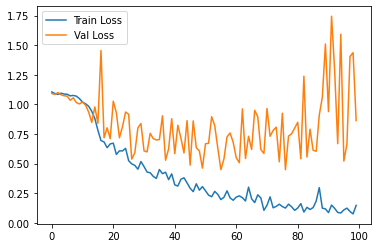

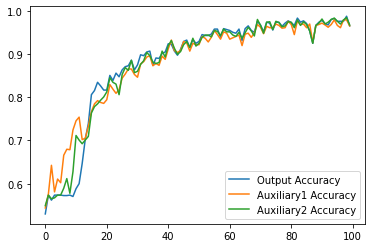

In [ ]:
import matplotlib.pyplot as plt
#Loss
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.legend()
plt.show()
#Accuracy
plt.plot(history.history['output_accuracy'], label = 'Output Accuracy')
plt.plot(history.history['auxiliary1_accuracy'], label = 'Auxiliary1 Accuracy')
plt.plot(history.history['auxiliary2_accuracy'], label = 'Auxiliary2 Accuracy')
plt.legend()
plt.show()

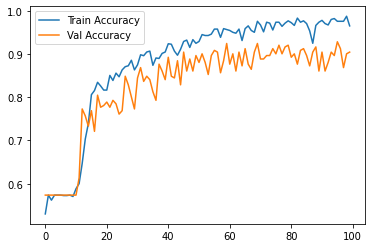

In [ ]:
plt.plot(history.history['output_accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_output_accuracy'], label = 'Val Accuracy')
plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/helmet_project/cat_soft_bi.h5')